In [5]:
import pandas as pd
import numpy as np
import torch
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from sklearn.model_selection import train_test_split

from transformers import (
    T5ForConditionalGeneration,
    T5TokenizerFast as T5Tokenizer,
    BartTokenizer,
    BartForConditionalGeneration,
    PreTrainedModel
)


from sklearn.metrics import mean_squared_error
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from datasets import load_metric
from sklearn.feature_extraction.text import TfidfVectorizer

from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple, Dict

from models.HeadlineGenerationModel import HeadlineGenerationModel
# from models.NewsHeadlineDataset import NewsHeadlineDataset
from models.NewsHeadlineDataModule import NewsHeadlineDataModule

In [6]:
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  drive.mount('/content/drive')
  PATH = '/content/drive/My Drive/UNI/sem6/NLP/project/articles_bbc.csv'
else:
  PATH = 'data/articles_bbc.csv'

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
data = pd.read_csv(PATH, index_col=0)
df = data[['Article','Headline']]
print(df.shape)
data.head(10)

(2225, 2)


,Article,Headline,Summary
0,Quarterly profits at US media giant TimeWarner...,Ad sales boost Time Warner profit,TimeWarner said fourth quarter sales rose 2% t...
1,The dollar has hit its highest level against t...,Dollar gains on Greenspan speech,The dollar has hit its highest level against t...
2,The owners of embattled Russian oil giant Yuko...,Yukos unit buyer faces loan claim,Yukos' owner Menatep Group says it will ask Ro...
3,British Airways has blamed high fuel prices fo...,High fuel prices hit BA's profits,"Rod Eddington, BA's chief executive, said the ..."
4,Shares in UK drinks and food firm Allied Domec...,Pernod takeover talk lifts Domecq,Pernod has reduced the debt it took on to fund...
5,Japan's economy teetered on the brink of a tec...,Japan narrowly escapes recession,"On an annual basis, the data suggests annual g..."
6,The US created fewer jobs than expected in Jan...,Jobs growth still slow in the US,The job gains mean that President Bush can cel...
7,"India, which attends the G7 meeting of seven l...",India calls for fair trade rules,At a conference on developing enterprise hoste...
8,Ethiopia produced 14.27 million tonnes of crop...,Ethiopia's crop production up 24%,"In 2003, crop production totalled 11.49 millio..."
9,A US government claim accusing the country's b...,Court rejects $280bn tobacco case,A US government claim accusing the country's b...


In [9]:
train_df, rest_df = train_test_split(df, test_size=0.2)
test_df, val_df = train_test_split(rest_df, test_size=0.5)

train_df.shape, val_df.shape, test_df.shape

((1780, 2), (223, 2), (222, 2))

# T5-small model fine-tuning

In [10]:
tokenizer = T5Tokenizer.from_pretrained('t5-small', model_max_length=512)

In [11]:
article_token_counts, headline_token_counts = [], []

for _, row in train_df.iterrows():
    article_token_count = len(tokenizer.encode(row["Article"]))
    article_token_counts.append(article_token_count)

    headline_token_count = len(tokenizer.encode(row["Headline"]))
    headline_token_counts.append(headline_token_count)

Token indices sequence length is longer than the specified maximum sequence length for this model (773 > 512). Running this sequence through the model will result in indexing errors


Text(0.5, 1.0, 'headline text token counts')

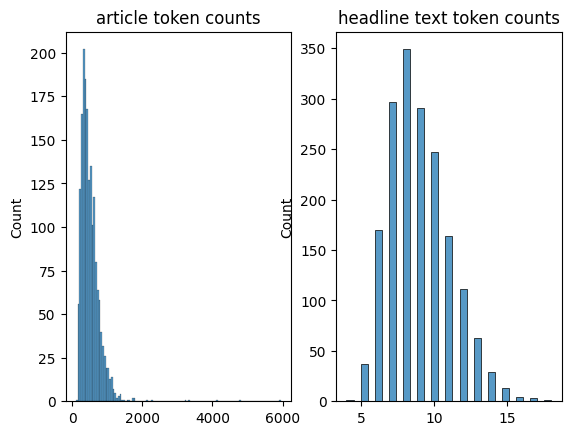

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2)

sns.histplot(article_token_counts, ax=ax1)
ax1.set_title("article token counts")

sns.histplot(headline_token_counts, ax=ax2)
ax2.set_title("headline text token counts")

In [13]:
data_module_t5 = NewsHeadlineDataModule(train_df, val_df, test_df, tokenizer, batch_size=8)

In [14]:
model_t5 = HeadlineGenerationModel("t5-small")

In [16]:
log_path = "logs/t5-small"
checkpoint_path = "checkpoints/t5-small"


checkpoint_callback = ModelCheckpoint(
    dirpath=checkpoint_path,
    filename="best-checkpoint-t5",
    save_top_k=1,
    verbose=True,
    monitor="val_loss",
    mode="min"
)

logger = TensorBoardLogger(log_path, name="news-headline")

trainer = pl.Trainer(
    logger=logger,
    callbacks=checkpoint_callback,
    max_epochs=10,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [18]:
trainer.fit(model_t5, data_module_t5)

# BART fine-tuning

In [19]:
tokenizer = BartTokenizer.from_pretrained("facebook/bart-base", model_max_length=512)

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

c:\Users\mkami\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:149: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\mkami\.cache\huggingface\hub\models--facebook--bart-base. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [20]:
data_module_bart = NewsHeadlineDataModule(train_df, val_df, test_df, tokenizer, batch_size=8)

In [21]:
model_bart = HeadlineGenerationModel("facebook/bart-base")

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

In [22]:
log_path = 'logs/bart'
checkpoint_path =  'checkpoints/bart'

checkpoint_callback = ModelCheckpoint(
    dirpath=checkpoint_path,
    filename="best-checkpoint-bart",
    save_top_k=1,
    verbose=True,
    monitor="val_loss",
    mode="min"
)

logger = TensorBoardLogger(log_path, name="news-headline")

trainer = pl.Trainer(
    logger=logger,
    callbacks=checkpoint_callback,
    max_epochs=10,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [23]:
# trainer.fit(model_bart, data_module_bart)

Missing logger folder: logs/bart\news-headline
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                         | Params
-------------------------------------------------------
0 | model | BartForConditionalGeneration | 139 M 
-------------------------------------------------------
139 M     Trainable params
0         Non-trainable params
139 M     Total params
557.682   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\mkami\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:436: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.
c:\Users\mkami\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\models\bart\modeling_bart.py:587: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
c:\Users\mkami\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Training: |          | 0/? [00:00<?, ?it/s]

c:\Users\mkami\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...
